In [107]:
# !conda install -y conda-forge::timezonefinder
# !conda install -y conda-forge::haversine
#!conda install -y conda-forge::py-xgboost
!conda install -y anaconda::libgomp

Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: \ ^C
unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



### Setting up libraries, importing datasets

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
from haversine import haversine, Unit
import datetime
import pytz
import math

In [57]:
astros = pd.read_csv("datathon_2024_dataset_corrected.csv")
stadiums = pd.read_csv("Stadiums.csv")
totaldistance = pd.read_csv("TotalDistance.csv")
location = pd.read_csv("StadiumLoc.csv")

In [58]:
## unimportant column
del stadiums["Image"]

### Adjusting Memory Usage

In [59]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.    
        Source Me :)    
    """

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [60]:
reduce_mem_usage(location)
reduce_mem_usage(stadiums)
reduce_mem_usage(astros)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.01 MB
Decreased by -96.0%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.01 MB
Decreased by -204.0%
Memory usage of dataframe is 12.18 MB
Memory usage after optimization is: 1.96 MB
Decreased by 83.9%


,Unnamed: 0,game_date,home_team,away_team,is_day_game,home_score,away_score,venue,venue_name,city,...,away_hbp,home_pa,home_1b,home_2b,home_3b,home_hr,home_fo,home_so,home_bb,home_hbp
0,0,20000329,NYN,CHN,0.0,3,5,TOK01,Tokyo Dome,Tokyo,...,1,38,5,1,0,1,24,4,3,0
1,1,20000330,CHN,NYN,0.0,1,5,TOK01,Tokyo Dome,Tokyo,...,1,44,5,0,0,0,24,9,6,0
2,2,20000403,ATL,COL,1.0,2,0,ATL02,Turner Field,Atlanta,...,0,32,5,0,0,2,17,6,1,1
3,3,20000403,CIN,MIL,1.0,3,3,CIN08,Cinergy Field,Cincinnati,...,0,20,3,1,0,1,10,4,1,0
4,4,20000403,FLO,SFN,0.0,6,4,MIA01,Sun Life Stadium,Miami,...,0,38,9,3,0,0,17,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56770,56770,20231001,CHA,SDN,1.0,1,2,CHI12,Guaranteed Rate Field;U.S. Cellular Field,Chicago,...,0,44,7,0,0,0,17,16,3,1
56771,56771,20231001,DET,CLE,1.0,5,2,DET05,Comerica Park,Detroit,...,0,38,4,4,0,1,16,7,6,0
56772,56772,20231001,KCA,NYA,1.0,5,2,KAN06,Kauffman Stadium,Kansas City,...,0,35,7,0,1,3,15,8,1,0
56773,56773,20231001,SEA,TEX,1.0,1,0,SEA03,Safeco Field,Seattle,...,0,30,4,0,0,0,14,10,1,1


# DATA CLEANING

### Adjusting labels and removing extraneous labels

In [61]:
#Change FLO to MIA - Name Change in 2011
astros["home_team"] = astros["home_team"].replace("FLO", "MIA")
astros["away_team"] = astros["away_team"].replace("FLO", "MIA")
#Change MON to WAS - Team bought in 2005, ease of use
astros["home_team"] = astros["home_team"].replace("MON", "WAS")
astros["away_team"] = astros["away_team"].replace("MON", "WAS")

In [8]:
astros

,Unnamed: 0,game_date,home_team,away_team,is_day_game,home_score,away_score,venue,venue_name,city,...,away_hbp,home_pa,home_1b,home_2b,home_3b,home_hr,home_fo,home_so,home_bb,home_hbp
0,0,20000329,NYN,CHN,0.0,3,5,TOK01,Tokyo Dome,Tokyo,...,1,38,5,1,0,1,24,4,3,0
1,1,20000330,CHN,NYN,0.0,1,5,TOK01,Tokyo Dome,Tokyo,...,1,44,5,0,0,0,24,9,6,0
2,2,20000403,ATL,COL,1.0,2,0,ATL02,Turner Field,Atlanta,...,0,32,5,0,0,2,17,6,1,1
3,3,20000403,CIN,MIL,1.0,3,3,CIN08,Cinergy Field,Cincinnati,...,0,20,3,1,0,1,10,4,1,0
4,4,20000403,MIA,SFN,0.0,6,4,MIA01,Sun Life Stadium,Miami,...,0,38,9,3,0,0,17,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56770,56770,20231001,CHA,SDN,1.0,1,2,CHI12,Guaranteed Rate Field;U.S. Cellular Field,Chicago,...,0,44,7,0,0,0,17,16,3,1
56771,56771,20231001,DET,CLE,1.0,5,2,DET05,Comerica Park,Detroit,...,0,38,4,4,0,1,16,7,6,0
56772,56772,20231001,KCA,NYA,1.0,5,2,KAN06,Kauffman Stadium,Kansas City,...,0,35,7,0,1,3,15,8,1,0
56773,56773,20231001,SEA,TEX,1.0,1,0,SEA03,Safeco Field,Seattle,...,0,30,4,0,0,0,14,10,1,1


### Modifying Stadium DataFrame: Changing name for formatting

In [62]:
location = location.rename(columns = {"X":"x", "Y":"y", "OBJECTID": "object_id", "NAME": "name", "CITY": "city", "STATE": "state", "CAPACITY":"capacity", "LATITUDE":"latitude", "LONGITUDE":"longitude", "LEAGUE":"league", "TEAM":"team"})
location["team"] = location["team"].replace({"Cleveland Indians":"Cleveland Guardians"})
lists = [ 'Location', 'Team', 'Roof type']
stad_merge = stadiums[lists]
stad_merge = stad_merge.rename(columns={ "Location":"location","Roof type":"roof_type", "Team":"team" })
stadiums = location.merge(stad_merge, how="inner", on="team")

In [63]:
#Manually changing the names of teams to their respective acronyms; also possible in spreadsheet 
 stadiums["team"] =  stadiums["team"].replace("Los Angeles Angels","ANA")
 stadiums["team"] =  stadiums["team"].replace("Arizona Diamondbacks","ARI")
 stadiums["team"] =  stadiums["team"].replace("Philadelphia Phillies","PHI")
 stadiums["team"] =  stadiums["team"].replace("Detroit Tigers","DET")
 stadiums["team"] =  stadiums["team"].replace("Colorado Rockies","COL")
 stadiums["team"] =  stadiums["team"].replace("Los Angeles Dodgers","LAN")
 stadiums["team"] =  stadiums["team"].replace("Boston Red Sox","BOS")
 stadiums["team"] =  stadiums["team"].replace("Cincinnati Reds","CIN")
 stadiums["team"] =  stadiums["team"].replace("Cleveland Guardians","CLE")
 stadiums["team"] =  stadiums["team"].replace("Kansas City Royals","KCA")
 stadiums["team"] =  stadiums["team"].replace("Milwaukee Brewers","MIL")
 stadiums["team"] =  stadiums["team"].replace("Houston Astros","HOU")
 stadiums["team"] =  stadiums["team"].replace("St. Louis Cardinals","SLN")
 stadiums["team"] =  stadiums["team"].replace("Baltimore Orioles","BAL")
 stadiums["team"] =  stadiums["team"].replace("San Francisco Giants","SFN")
 stadiums["team"] =  stadiums["team"].replace("San Diego Padres","SDN")
 stadiums["team"] =  stadiums["team"].replace("Pittsburgh Pirates","PIT")
 stadiums["team"] =  stadiums["team"].replace("Seattle Mariners","SEA")
 stadiums["team"] =  stadiums["team"].replace("New York Mets","NYN")
 stadiums["team"] =  stadiums["team"].replace("Texas Rangers","TEX")
 stadiums["team"] =  stadiums["team"].replace("Tampa Bay Rays","TBA")
 stadiums["team"] =  stadiums["team"].replace("Chicago White Sox","CHA")
 stadiums["team"] =  stadiums["team"].replace("Chicago Cubs","CHN")
 stadiums["team"] =  stadiums["team"].replace("New York Yankees","NYA")
 stadiums["team"] =  stadiums["team"].replace("Washington Nationals","WAS")
 stadiums["team"] =  stadiums["team"].replace("Toronto Blue Jays","TOR")
 stadiums["team"] =  stadiums["team"].replace("Minnesota Twins","MIN")
 stadiums["team"] =  stadiums["team"].replace("Miami Marlins","MIA")
 stadiums["team"] =  stadiums["team"].replace("Oakland Athletics","OAK")
 stadiums["team"] =  stadiums["team"].replace("Atlanta Braves","ATL")

In [64]:
## repeated columns
 del stadiums["x"]
 del stadiums["y"]
 del stadiums["city"]

## reconciling different column names across dataframes
stadiums = stadiums.rename(columns={"team":"home_team"})

### Adding columns to Astros Dataframe: Year, Batting Average, Win category

In [65]:
## Adding a "Year" column by splicing the date column for the first four numbers
astros["game_date"] = astros["game_date"].apply(str)
astros["year"] = astros["game_date"].str.slice(0,4)

## Calculating Batting average manually with given data
astros["home_ba"] = (astros["home_1b"] + astros["home_2b"] + astros["home_3b"] + astros["home_hr"])/astros["home_pa"]
astros["away_ba"] = (astros["away_1b"] + astros["away_2b"] + astros["away_3b"] + astros["away_hr"])/astros["away_pa"]

## Categorizing each game's "victory status" based on a score comparison
astros["Win"] = np.where(astros["home_score"] > astros["away_score"], 1, 0)

### Reconciling differences in two datasets: finding the extra team names

In [66]:
x = astros["home_team"].unique()
test = pd.DataFrame(x)
test["home_team"] = x
print(x.tolist())

['NYN', 'CHN', 'ATL', 'CIN', 'MIA', 'WAS', 'SLN', 'ANA', 'BAL', 'MIN', 'OAK', 'TEX', 'TOR', 'ARI', 'PIT', 'SEA', 'HOU', 'KCA', 'TBA', 'COL', 'MIL', 'PHI', 'SDN', 'SFN', 'BOS', 'DET', 'NYA', 'LAN', 'CHA', 'CLE']


In [67]:
## This tells us whether there are differences between the two columns, helpful before merging
index1 = pd.Index(test["home_team"])
index2 = pd.Index(stadiums["home_team"])
index1.difference(index2).values

[], Categories (30, object): ['ANA', 'ARI', 'ATL', 'BAL', ..., 'TBA', 'TEX', 'TOR', 'WAS']

In [15]:
stadiums

,object_id,name,state,capacity,latitude,longitude,league,home_team,location,roof_type
0,1,Angel Stadium,CA,45050,33.812500,-117.8750,American,ANA,"Anaheim, California",Open
1,2,Chase Field,AZ,48633,33.437500,-112.0625,National,ARI,"Phoenix, Arizona",Retractable
2,3,Citizens Bank Park,PA,43651,39.906250,-75.1875,National,PHI,"Philadelphia, Pennsylvania",Open
3,4,Comerica Park,MI,41681,42.343750,-83.0625,American,DET,"Detroit, Michigan",Open
4,5,Coors Field,CO,50490,39.750000,-105.0000,National,COL,"Denver, Colorado",Open
5,6,Dodger Stadium,CA,56000,34.062500,-118.2500,National,LAN,"Los Angeles, California",Open
6,7,Fenway Park,MA,37493,42.343750,-71.1250,American,BOS,"Boston, Massachusetts",Open
7,8,Great American Ballpark,OH,42319,39.093750,-84.5000,National,CIN,"Cincinnati, Ohio",Open
8,9,Progressive Field,OH,43441,41.500000,-81.6875,American,CLE,"Cleveland, Ohio",Open
9,10,Kauffman Stadium,MO,37903,39.062500,-94.5000,American,KCA,"Kansas City, Missouri",Open


### Adding Timezone based on latitude and longitude

In [68]:
## Method that applies a timezone based on geographical location
time_func = TimezoneFinder().timezone_at
stadiums["timezone"] = stadiums.apply(lambda x: time_func(lng = x["longitude"], lat = x["latitude"]), axis = 1)
stadiums["timezone"].unique()

array(['America/Los_Angeles', 'America/Phoenix', 'America/New_York',
       'America/Detroit', 'America/Denver', 'America/Chicago',
       'America/Toronto'], dtype=object)

In [69]:
# Map timezone numerically
stadiums

,object_id,name,state,capacity,latitude,longitude,league,home_team,location,roof_type,timezone
0,1,Angel Stadium,CA,45050,33.812500,-117.8750,American,ANA,"Anaheim, California",Open,America/Los_Angeles
1,2,Chase Field,AZ,48633,33.437500,-112.0625,National,ARI,"Phoenix, Arizona",Retractable,America/Phoenix
2,3,Citizens Bank Park,PA,43651,39.906250,-75.1875,National,PHI,"Philadelphia, Pennsylvania",Open,America/New_York
3,4,Comerica Park,MI,41681,42.343750,-83.0625,American,DET,"Detroit, Michigan",Open,America/Detroit
4,5,Coors Field,CO,50490,39.750000,-105.0000,National,COL,"Denver, Colorado",Open,America/Denver
5,6,Dodger Stadium,CA,56000,34.062500,-118.2500,National,LAN,"Los Angeles, California",Open,America/Los_Angeles
6,7,Fenway Park,MA,37493,42.343750,-71.1250,American,BOS,"Boston, Massachusetts",Open,America/New_York
7,8,Great American Ballpark,OH,42319,39.093750,-84.5000,National,CIN,"Cincinnati, Ohio",Open,America/New_York
8,9,Progressive Field,OH,43441,41.500000,-81.6875,American,CLE,"Cleveland, Ohio",Open,America/New_York
9,10,Kauffman Stadium,MO,37903,39.062500,-94.5000,American,KCA,"Kansas City, Missouri",Open,America/Chicago


In [70]:
## Encoding timezones numerically for later quantitative analysis
# PST: 0
# MST: 1
# CST: 2
# EST: 3

stadiums["timezone"] = stadiums["timezone"].replace("America/Los_Angeles", 0)
stadiums["timezone"] = stadiums["timezone"].replace("America/Phoenix", 1)
stadiums["timezone"] = stadiums["timezone"].replace("America/Chicago", 2)
stadiums["timezone"] = stadiums["timezone"].replace("America/Denver", 1)
stadiums["timezone"] = stadiums["timezone"].replace("America/Toronto", 3)
stadiums["timezone"] = stadiums["timezone"].replace("America/New_York", 3)
stadiums["timezone"] = stadiums["timezone"].replace("America/Detroit", 3)
stadiums["timezone"].unique()


array([0, 1, 3, 2])

### Merging main and stadium dataframes

In [71]:
merger = pd.merge(stadiums, astros, on= "home_team")

In [72]:
merger = merger.sort_values(by='game_date')

In [ ]:
merger 

,object_id,name,state_x,capacity,latitude,longitude,league,home_team,location,roof_type,...,away_3b,away_hr,away_fo,away_so,away_bb,away_hbp,year,home_ba,away_ba,Win
0,1,Angel Stadium,CA,45050,33.81250,-117.8750,American,ANA,"Anaheim, California",Open,...,0,1,19,6,5,0,2000,0.171429,0.250000,0
24438,14,Oriole Park at Camden Yards,MD,45363,39.28125,-76.6250,American,BAL,"Baltimore, Maryland",Open,...,0,0,16,8,7,0,2000,0.171429,0.162162,0
22564,13,Busch Stadium,MO,43975,38.62500,-90.1875,National,SLN,"St. Louis, Missouri",Open,...,1,3,18,6,7,0,2000,0.093750,0.243902,1
50392,28,Marlins Park,FL,37000,25.78125,-80.2500,National,MIA,"Miami, Florida",Retractable,...,0,0,17,7,1,1,2000,0.277778,0.315789,1
35691,20,Global Life Park in Arlington,TX,48114,32.75000,-97.0625,American,TEX,"Arlington, Texas",Retractable,...,0,4,17,6,4,2,2000,0.277778,0.275000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,10,Kauffman Stadium,MO,37903,39.06250,-94.5000,American,KCA,"Kansas City, Missouri",Open,...,1,3,15,8,1,0,2023,0.200000,0.314286,1
24437,13,Busch Stadium,MO,43975,38.62500,-90.1875,National,SLN,"St. Louis, Missouri",Open,...,0,0,14,9,1,2,2023,0.257143,0.257143,1
9390,5,Coors Field,CO,50490,39.75000,-105.0000,National,COL,"Denver, Colorado",Open,...,0,2,14,17,2,0,2023,0.191489,0.108108,1
41365,22,Guaranteed Rate Field,IL,40615,41.84375,-87.6250,American,CHA,"Chicago, Illinois",Open,...,0,0,17,16,3,1,2023,0.159091,0.159091,0


### Creating second merged DataFrame to include coordinates for away team original stadiums

In [ ]:
merger2

,object_id,name,state_x,capacity,latitude_x,longitude_x,league,home_team,location,roof_type,...,away_hbp,year,home_ba,away_ba,Win,latitude_y,longitude_y,timezone_y,distance,lat_long
0,19,Citi Field,NY,41800,40.75000,-73.8750,National,NYN,"Queens, New York",Open,...,0,2000,0.266667,0.184211,0,41.9375,-87.625,America/Chicago,717.165263,"40.75, -73.9"
1,13,Busch Stadium,MO,43975,38.62500,-90.1875,National,SLN,"St. Louis, Missouri",Open,...,0,2000,0.093750,0.243902,1,41.9375,-87.625,America/Chicago,265.723145,"38.62, -90.2"
2,13,Busch Stadium,MO,43975,38.62500,-90.1875,National,SLN,"St. Louis, Missouri",Open,...,0,2000,0.236842,0.292683,1,41.9375,-87.625,America/Chicago,265.723145,"38.62, -90.2"
3,13,Busch Stadium,MO,43975,38.62500,-90.1875,National,SLN,"St. Louis, Missouri",Open,...,1,2000,0.171429,0.261905,1,41.9375,-87.625,America/Chicago,265.723145,"38.62, -90.2"
4,8,Great American Ballpark,OH,42319,39.09375,-84.5000,National,CIN,"Cincinnati, Ohio",Open,...,0,2000,0.195122,0.200000,0,41.9375,-87.625,America/Chicago,255.987605,"39.1, -84.5"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55960,14,Oriole Park at Camden Yards,MD,45363,39.28125,-76.6250,American,BAL,"Baltimore, Maryland",Open,...,0,2023,0.096774,0.200000,1,38.8750,-77.000,America/New_York,34.531614,"39.28, -76.6"
55961,14,Oriole Park at Camden Yards,MD,45363,39.28125,-76.6250,American,BAL,"Baltimore, Maryland",Open,...,1,2023,0.187500,0.230769,1,38.8750,-77.000,America/New_York,34.531614,"39.28, -76.6"
55962,30,SunTrust Park,GA,41084,33.87500,-84.4375,National,ATL,"Cumberland, Georgia",Open,...,1,2023,0.238095,0.354167,0,38.8750,-77.000,America/New_York,538.673714,"33.88, -84.44"
55963,30,SunTrust Park,GA,41084,33.87500,-84.4375,National,ATL,"Cumberland, Georgia",Open,...,1,2023,0.250000,0.282051,1,38.8750,-77.000,America/New_York,538.673714,"33.88, -84.44"


### Calculating Distance between two geographical points: Haversine function

In [73]:
#Miles Conversion
## Haversine formula gives us an estimate of the shortest distance between two geographical points
## This assumes that the Earth is perfectly spherical and that MLB players take the shortest route between cities
## The formula is cited

loc1=(28.426846,77.088834)
loc2=(28.394231,77.050308)
import haversine as hs
hs.haversine(loc1,loc2, unit=Unit.MILES)
hs.haversine((20,10),(40,30), unit = Unit.MILES)

1818.9953390720743

### Deleting Extraneous Locations: Tokyo, Puerto Rico, ...

In [74]:
y = merger["city"].unique()
mergertest = pd.DataFrame(y)
mergertest

,0
0,Tokyo
1,Anaheim
2,Cincinnati
3,Atlanta
4,Miami
5,Montreal
6,Toronto
7,Minneapolis
8,Arlington
9,Baltimore


In [75]:
## These locations were often alternate locations/neutral games where neither team had homefield advantage
## Removing them as "outliers" considering the hypothesis is based on home vs. away.

merger = merger[merger["city"] != "Tokyo"]
merger = merger[merger["city"] != "San Juan"]
merger = merger[merger["city"] != "Sydney"]
merger = merger[merger["city"] != "Lake Buena Vista"]
merger = merger[merger["city"] != "Fort Bragg"]
merger = merger[merger["city"] != "Monterrey"]
merger = merger[merger["city"] != "Williamsport"]
merger = merger[merger["city"] != "Omaha"]
merger = merger[merger["city"] != "London"]
merger = merger[merger["city"] != "Dyersville"]

### Back to Back counter

In [76]:
#B2B counter 

#Dictionary Counter with team names and values
#Starts at zero if team name is away counter goes to 1

## This tells us the number of consecutive away games a team has played

#Seperate Dictionary of Lists
#Away Team : Stores Name of teams at home 
# Previous Team Loc Vairable
B2BList = ['NYN', 'CHN', 'ATL', 'CIN', 'MIA', 'SLN', 'ANA', 'BAL', 'MIN', 'OAK', 'TEX', 'TOR', 'ARI', 'PIT', 'SEA', 'HOU', 'KCA', 'TBA', 'COL', 'MIL', 'PHI', 'SDN', 'SFN', 'BOS', 'DET', 'NYA', 'LAN', 'CHA', 'CLE', 'WAS']


In [77]:
merger.columns

Index(['object_id', 'name', 'state_x', 'capacity', 'latitude', 'longitude',
       'league', 'home_team', 'location', 'roof_type', 'timezone',
       'Unnamed: 0', 'game_date', 'away_team', 'is_day_game', 'home_score',
       'away_score', 'venue', 'venue_name', 'city', 'state_y', 'away_pa',
       'away_1b', 'away_2b', 'away_3b', 'away_hr', 'away_fo', 'away_so',
       'away_bb', 'away_hbp', 'home_pa', 'home_1b', 'home_2b', 'home_3b',
       'home_hr', 'home_fo', 'home_so', 'home_bb', 'home_hbp', 'year',
       'home_ba', 'away_ba', 'Win'],
      dtype='object')

In [179]:
B2BList = ['NYN', 'CHN', 'ATL', 'CIN', 'MIA', 'SLN', 'ANA', 'BAL', 'MIN', 'OAK', 'TEX', 'TOR', 'ARI', 'PIT', 'SEA', 'HOU', 'KCA', 'TBA', 'COL', 'MIL', 'PHI', 'SDN', 'SFN', 'BOS', 'DET', 'NYA', 'LAN', 'CHA', 'CLE', 'WAS']
New_proc = pd.DataFrame(columns = ['object_id', 'name', 'state_x', 'capacity', 'latitude', 'longitude',
       'league', 'home_team', 'location', 'roof_type', 'timezone',
       'Unnamed: 0', 'game_date', 'away_team', 'is_day_game', 'home_score',
       'away_score', 'venue', 'venue_name', 'city', 'state_y', 'home_pa',
       'home_1b', 'home_2b', 'home_3b', 'home_hr', 'home_fo', 'home_so',
       'home_bb', 'home_hbp', 'away_pa', 'away_1b', 'away_2b', 'away_3b',
       'away_hr', 'away_fo', 'away_so', 'away_bb', 'away_hbp', 'year',
       'home_ba', 'away_ba', 'Win'])
for i in range(len(B2BList)):
    H = merger[merger['home_team'] == B2BList[i]  ]  
    A = merger[merger['away_team'] == B2BList[i]  ]
    Tot = pd.concat([H, A])
    #Set Game Date to datetime
    Tot = Tot.sort_values(by='game_date')
    Tot = pd.DataFrame(Tot)
    Tot['game_date'] = pd.to_datetime(Tot['game_date'],format='%Y%m%d' )
    #Get previous lat and long
    Tot['prev_long'] = Tot['longitude'].shift()
    Tot['prev_lat'] = Tot['latitude'].shift()
    Tot['prev_long'].iloc[0] = Tot['longitude'].iloc[0]
    Tot['prev_lat'].iloc[0] = Tot['latitude'].iloc[0]

    Tot['prev_tz'] = Tot['timezone'].shift()
    Tot['prev_tz'].iloc[0] = Tot['timezone'].iloc[0]

    #Remove home games
    Tot = Tot[Tot['away_team'] == B2BList[i]]
    #Concat to dataframe
    New_proc = pd.concat([New_proc, Tot])


Merger = New_proc

/tmp/ipykernel_61/1751811928.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tot['prev_long'].iloc[0] = Tot['longitude'].iloc[0]
/tmp/ipykernel_61/1751811928.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tot['prev_lat'].iloc[0] = Tot['latitude'].iloc[0]
/tmp/ipykernel_61/1751811928.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tot['prev_tz'].iloc[0] = Tot['timezone'].iloc[0]
/tmp/ipykernel_61/1751811928.py:21: Settin

In [191]:
Merger

,object_id,name,state_x,capacity,latitude,longitude,league,home_team,location,roof_type,...,away_hbp,year,home_ba,away_ba,Win,prev_long,prev_lat,prev_tz,distance_traveled,timezone_change
3789,3,Citizens Bank Park,PA,43651,39.90625,-75.1875,National,PHI,"Philadelphia, Pennsylvania",Open,...,0,2000,0.264706,0.250000,1,-73.8750,40.75000,3.0,90.430843,0
3790,3,Citizens Bank Park,PA,43651,39.90625,-75.1875,National,PHI,"Philadelphia, Pennsylvania",Open,...,0,2000,0.279070,0.184211,1,-75.1875,39.90625,3.0,0.000000,0
3791,3,Citizens Bank Park,PA,43651,39.90625,-75.1875,National,PHI,"Philadelphia, Pennsylvania",Open,...,0,2000,0.138889,0.190476,0,-75.1875,39.90625,3.0,0.000000,0
30296,17,PNC Park,PA,38362,40.43750,-80.0000,National,PIT,"Pittsburgh, Pennsylvania",Open,...,0,2000,0.203704,0.338983,0,-75.1875,39.90625,3.0,256.680845,0
30297,17,PNC Park,PA,38362,40.43750,-80.0000,National,PIT,"Pittsburgh, Pennsylvania",Open,...,1,2000,0.142857,0.151515,1,-80.0000,40.43750,3.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26491,14,Oriole Park at Camden Yards,MD,45363,39.28125,-76.6250,American,BAL,"Baltimore, Maryland",Open,...,0,2023,0.200000,0.096774,1,-77.0000,38.87500,3.0,34.531614,0
26492,14,Oriole Park at Camden Yards,MD,45363,39.28125,-76.6250,American,BAL,"Baltimore, Maryland",Open,...,0,2023,0.230769,0.187500,1,-76.6250,39.28125,3.0,0.000000,0
56772,30,SunTrust Park,GA,41084,33.87500,-84.4375,National,ATL,"Cumberland, Georgia",Open,...,0,2023,0.354167,0.238095,0,-76.6250,39.28125,3.0,571.803037,0
56773,30,SunTrust Park,GA,41084,33.87500,-84.4375,National,ATL,"Cumberland, Georgia",Open,...,0,2023,0.282051,0.250000,1,-84.4375,33.87500,3.0,0.000000,0


In [180]:
## Using the haversine function to calculate distance between current location and previous location for away team
Merger["distance_traveled"] = Merger.apply(lambda x: hs.haversine((x["latitude"], x["longitude"]), ((x["prev_lat"]), x["prev_long"]), unit = Unit.MILES), axis = 1)

## Calculating the numerical difference in timezones between current timezone and previous timezone for away team
Merger["timezone_change"] = Merger["timezone"].astype(int)-Merger["prev_tz"].astype(int)

### Distance between home stadium and away stadium calculation

In [80]:
stadiums2 = stadiums
stadiums2 = stadiums2[["latitude", "longitude", "home_team"]]
stadiums2 = stadiums2.rename(columns={"home_team":"away_team"})
stadiums2["timezone"] = stadiums2.apply(lambda x: time_func(lng = x["longitude"], lat = x["latitude"]), axis = 1)

In [81]:
merger2 = pd.merge(merger, stadiums2, on = "away_team")

In [82]:
merger2["distance_from_home"] = merger2.apply(lambda x: hs.haversine((x["latitude_x"], x["longitude_x"]), (x["latitude_y"], x["longitude_y"]), unit = Unit.MILES), axis = 1)

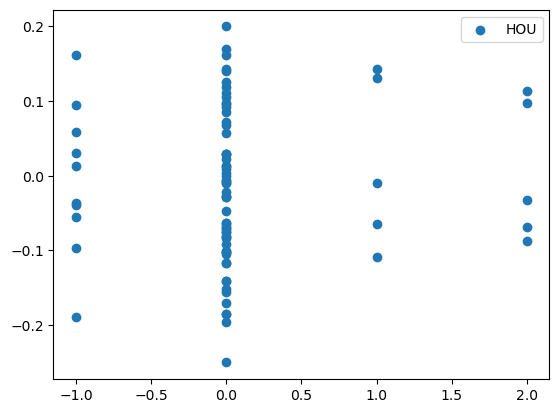

In [190]:
H = Merger[Merger['home_team'] == 'HOU' ]  
# A = Merger[Merger['away_team'] == 'HOU' ]
# A = A[A['year'] == '2003' ]
H = H[H['year'] =='2008' ]
#Tot = pd.concat([H, A])
Tot = H
plt.scatter(Tot["timezone_change"], Tot["away_ba"] - Tot["home_ba"], label = 'HOU')
plt.legend()

In [178]:
Tot  

,object_id,name,state_x,capacity,latitude,longitude,league,home_team,location,roof_type,...,away_hbp,year,home_ba,away_ba,Win,prev_long,prev_lat,prev_tz,distance_traveled,timezone_change


# Baseline Creation

In [98]:
## Pivot tables created to show average values teamwide for each year.

pivot_away_ba = pd.pivot_table(Merger, values = "away_ba", index = "year", columns = "away_team", aggfunc = np.mean)
pivot_home_ba = pd.pivot_table(Merger, values = "home_ba", index = "year", columns = "home_team", aggfunc = np.mean)
pivot_away_dist = pd.pivot_table(Merger, values = "distance_traveled", index = "year", columns = "away_team", aggfunc = np.mean)
pivot_away_tz = pd.pivot_table(Merger, values = "timezone_change", index = "year", columns = "away_team", aggfunc = np.mean)

In [99]:
pivot_away_ba

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
away_team,,,,,,,,,,,,,,,,,,,,,
ANA,0.236925,0.221839,0.250435,0.231204,0.249936,0.245635,0.239195,0.230899,0.227171,0.246387,...,0.233312,0.213017,0.229252,0.204997,0.215425,0.211902,0.198866,0.209066,0.197961,0.221548
ARI,0.219249,0.222068,0.217244,0.220351,0.213748,0.217737,0.218288,0.209928,0.199785,0.204370,...,0.212425,0.228311,0.222946,0.203083,0.199992,0.222423,0.195053,0.193419,0.199941,0.209530
ATL,0.226903,0.224661,0.223429,0.247157,0.235129,0.215427,0.225476,0.249412,0.226237,0.231707,...,0.213559,0.225089,0.220599,0.228562,0.226067,0.221720,0.229305,0.207372,0.222579,0.237854
BAL,0.238816,0.220176,0.216375,0.231660,0.245926,0.244609,0.231303,0.232141,0.226743,0.220460,...,0.224843,0.208031,0.225727,0.225772,0.208845,0.216633,0.241226,0.201805,0.204833,0.225830
BOS,0.225089,0.226920,0.244129,0.230355,0.225267,0.242617,0.215995,0.224772,0.232197,0.219446,...,0.206132,0.213156,0.232051,0.214280,0.221894,0.226956,0.226072,0.213969,0.210857,0.209552
CHA,0.242883,0.232618,0.223636,0.229723,0.226082,0.236340,0.244982,0.215298,0.220275,0.231544,...,0.225841,0.224627,0.226776,0.230633,0.209159,0.237687,0.227005,0.220251,0.232447,0.209145
CHN,0.215938,0.219175,0.218847,0.228383,0.231138,0.238247,0.227305,0.236224,0.228992,0.212047,...,0.207646,0.220504,0.220899,0.211565,0.222565,0.210124,0.196471,0.204795,0.198894,0.215806
CIN,0.232969,0.227228,0.214807,0.207344,0.222268,0.219345,0.211496,0.233460,0.207861,0.211152,...,0.207800,0.213677,0.224138,0.222402,0.219308,0.206119,0.174527,0.205459,0.199511,0.219190
CLE,0.239260,0.238165,0.217672,0.229897,0.245580,0.243258,0.245304,0.227434,0.220655,0.233981,...,0.219151,0.209340,0.209842,0.227416,0.216405,0.216474,0.187107,0.209586,0.225163,0.221791


In [86]:
pivot_home

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
home_team,,,,,,,,,,,,,,,,,,,,,
ARI,0.242267,0.240737,0.239619,0.238001,0.237652,0.220973,0.248009,0.225155,0.230982,0.235850,...,0.232154,0.238391,0.238370,0.239842,0.209765,0.215920,0.225807,0.220934,0.201332,0.227249
ATL,0.240011,0.232636,0.229429,0.249065,0.227992,0.247509,0.244583,0.227640,0.238794,0.221389,...,0.214028,0.217377,0.227601,0.235543,0.221948,0.225011,0.233143,0.212980,0.227697,0.245777
BAL,0.234869,0.210044,0.218761,0.244566,0.248350,0.233766,0.255544,0.248684,0.243208,0.254954,...,0.232548,0.237857,0.229883,0.241458,0.217843,0.219913,0.211598,0.222540,0.209994,0.219980
BOS,0.239200,0.241618,0.239028,0.272081,0.264576,0.241100,0.246469,0.252118,0.247996,0.242145,...,0.222096,0.256518,0.263664,0.238344,0.248233,0.240500,0.247836,0.244372,0.241851,0.246926
CHN,0.224278,0.225394,0.204636,0.225835,0.240801,0.242142,0.249070,0.244214,0.249004,0.229541,...,0.216540,0.202898,0.214539,0.225289,0.223200,0.225652,0.176422,0.206782,0.215699,0.222815
CHA,0.249389,0.236227,0.242220,0.231279,0.238534,0.228211,0.246133,0.214730,0.236415,0.218361,...,0.227554,0.219948,0.229709,0.222849,0.222094,0.230882,0.229888,0.221921,0.225332,0.217571
CIN,0.246596,0.232579,0.220952,0.217150,0.208930,0.230971,0.231062,0.231227,0.218244,0.217897,...,0.213250,0.223955,0.226710,0.219213,0.221740,0.219619,0.190548,0.224213,0.215507,0.213536
CLE,0.255854,0.244276,0.216129,0.220147,0.230103,0.232245,0.243219,0.235997,0.232262,0.220227,...,0.226152,0.238373,0.249212,0.225376,0.229841,0.214223,0.202241,0.208591,0.223711,0.220394
COL,0.283841,0.290209,0.273835,0.252467,0.260818,0.261643,0.252106,0.255668,0.239487,0.244244,...,0.284666,0.271105,0.265957,0.260889,0.252739,0.263843,0.254511,0.246965,0.250945,0.239768


In [93]:
pivot_away_dist

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
away_team,,,,,,,,,,,,,,,,,,,,,
ANA,333.085091,360.353670,327.185333,336.912047,386.910271,403.947609,364.046452,440.057819,407.447088,367.175548,...,405.999096,319.577870,333.842598,383.972877,331.091283,355.225664,244.098809,348.915119,318.871151,334.836625
ARI,285.238334,258.057923,291.295559,308.606448,325.761622,287.727205,279.071102,278.589590,251.820619,350.209074,...,281.813914,254.108571,299.193011,294.581135,333.308725,268.953442,188.073859,291.040081,277.301853,352.169701
ATL,247.460590,219.591378,278.870371,294.301900,231.780860,252.657544,273.363409,240.601268,300.827612,239.868215,...,287.541361,223.057269,241.272112,291.254309,232.390803,316.006584,151.944772,233.575541,244.912851,276.351679
BAL,307.624850,288.415081,291.476128,276.056084,356.013338,303.564535,229.415376,253.343829,276.643761,249.756664,...,216.666149,223.788872,312.235851,193.935309,239.028055,221.616781,114.903035,227.552576,274.664750,319.028854
BOS,264.302455,317.517107,301.791768,271.544951,338.147908,280.284384,261.338188,320.019549,374.746721,297.476783,...,303.409424,275.491679,337.067637,266.304652,285.683548,252.524158,152.618418,250.082486,263.710265,274.733259
CHA,286.839158,248.714047,242.234731,226.510690,248.326877,245.499048,243.660855,260.024458,208.292807,215.094436,...,244.107683,189.937144,237.050724,261.233378,200.401655,276.383257,123.282862,216.178829,226.022992,230.518808
CHN,218.760393,201.460539,239.428444,208.369517,239.285359,205.260015,227.088243,207.839912,238.414923,249.883601,...,204.112332,177.697846,222.003447,199.128682,238.889984,243.028362,110.660145,240.781621,229.746173,196.913654
CIN,252.665145,227.200741,224.648868,226.656496,251.590356,202.340273,201.868946,279.697759,231.321751,254.423644,...,196.825316,190.062994,206.892365,224.520148,153.503776,242.436157,110.670440,214.670308,217.722876,230.691072
CLE,242.929515,222.006696,278.123231,246.310086,226.336295,228.712840,276.548730,267.340103,259.462104,210.639707,...,242.208926,224.398061,244.284271,246.165819,219.020976,237.530964,125.968968,212.490122,242.857195,234.807445


In [96]:
pivot_away_tz

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
away_team,,,,,,,,,,,,,,,,,,,,,
ANA,0.246914,0.259259,0.271605,0.298701,0.271605,0.185185,0.172840,0.185185,0.246914,0.222222,...,0.209877,0.172840,0.296296,0.209877,0.197531,0.259259,0.172414,0.189873,0.283951,0.246914
ARI,0.123457,0.074074,0.098765,0.037037,0.074074,0.000000,0.086420,0.098765,0.074074,-0.049383,...,0.086420,0.074074,0.024691,0.012346,0.000000,0.098765,0.000000,0.049383,0.086420,0.074074
ATL,-0.123457,-0.111111,-0.050000,-0.076923,-0.128205,-0.037037,-0.086420,-0.111111,-0.086420,-0.086420,...,-0.098765,-0.061728,-0.100000,-0.086420,-0.111111,-0.074074,0.000000,-0.086420,-0.123457,-0.123457
BAL,-0.074074,-0.073171,-0.135802,-0.121951,-0.074074,-0.037037,-0.086420,-0.123457,-0.061728,-0.086420,...,-0.061728,-0.059524,-0.111111,-0.086420,-0.049383,-0.123457,0.000000,-0.086420,-0.024691,-0.074074
BOS,-0.061728,-0.050000,-0.111111,-0.098765,-0.123457,-0.074074,-0.098765,-0.086420,-0.063291,-0.098765,...,-0.037037,-0.074074,-0.061728,-0.098765,-0.037037,-0.111111,0.000000,-0.098765,-0.100000,-0.135802
CHA,0.098765,0.049383,0.012346,-0.012346,0.061728,0.012346,0.086420,0.049383,0.000000,0.000000,...,0.024691,0.000000,0.049383,0.037037,0.049383,0.111111,0.100000,0.049383,-0.012346,0.024691
CHN,-0.012500,-0.024691,0.037037,0.025641,0.012500,-0.037037,0.061728,0.049383,0.050000,-0.061728,...,0.061728,0.024691,0.012346,0.024691,0.037037,-0.025000,0.111111,0.037037,0.025000,0.024691
CIN,-0.209877,-0.185185,-0.135802,-0.153846,-0.148148,-0.148148,-0.123457,-0.098765,-0.111111,-0.135802,...,-0.111111,-0.098765,-0.148148,-0.123457,-0.123457,-0.172840,-0.129032,-0.148148,-0.135802,-0.148148
CLE,-0.185185,-0.121951,-0.172840,-0.148148,-0.185185,-0.160494,-0.123457,-0.121951,-0.148148,-0.111111,...,-0.160494,-0.148148,-0.075000,-0.148148,-0.151899,-0.135802,-0.066667,-0.111111,-0.123457,-0.160494


# VISUALIZATIONS

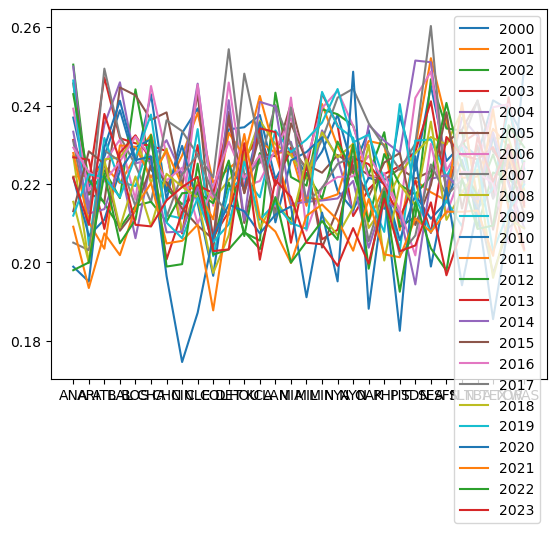

In [125]:
for index, row in pivot_away_ba.iterrows():
    plt.plot(row, label = index)
plt.legend()
plt.show()

In [ ]:
sns.displot(Merger, x = "home_ba", hue = "home_team")

/tmp/ipykernel_61/662513441.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


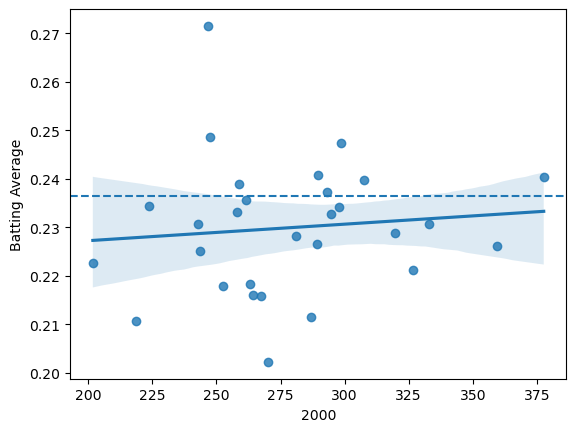

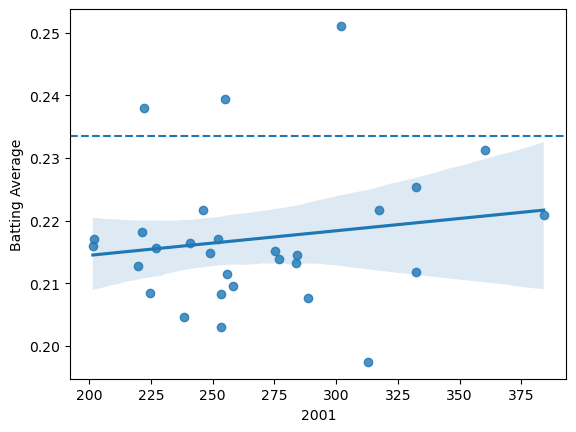

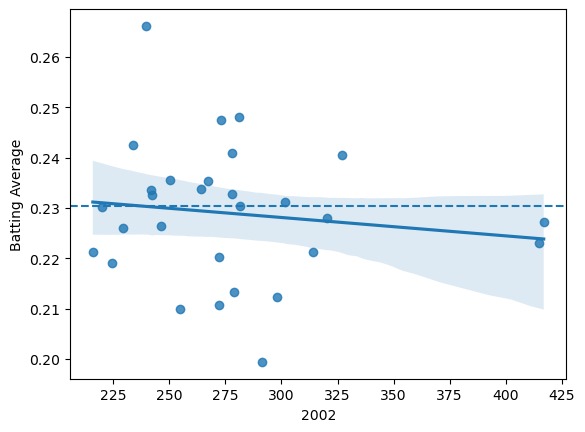

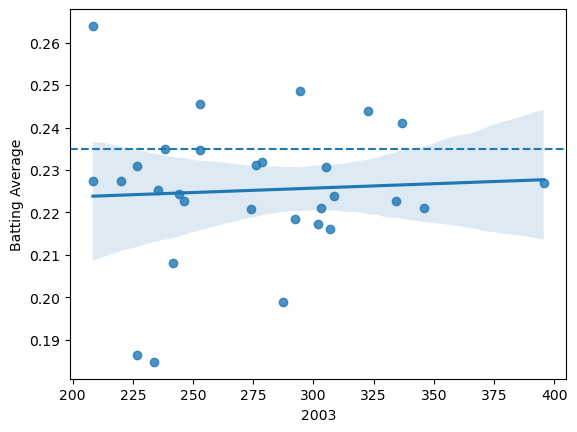

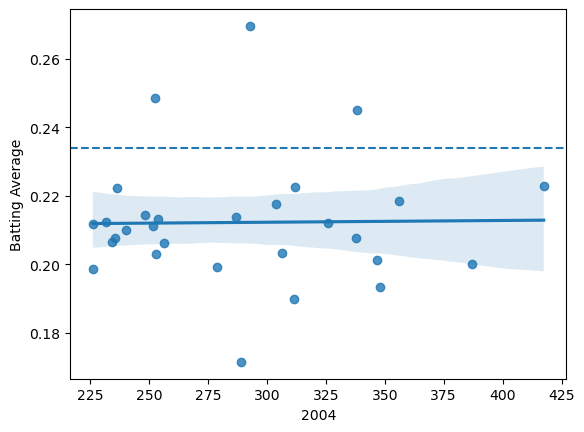

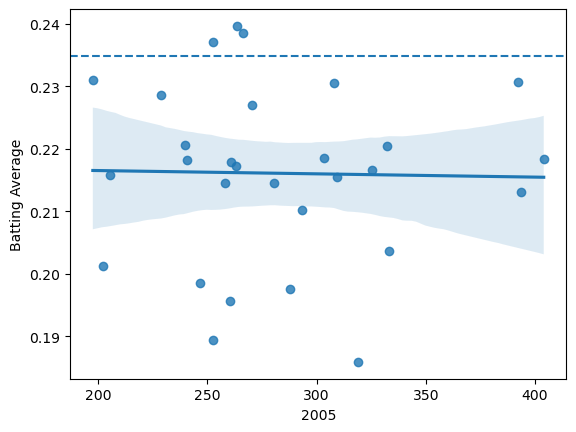

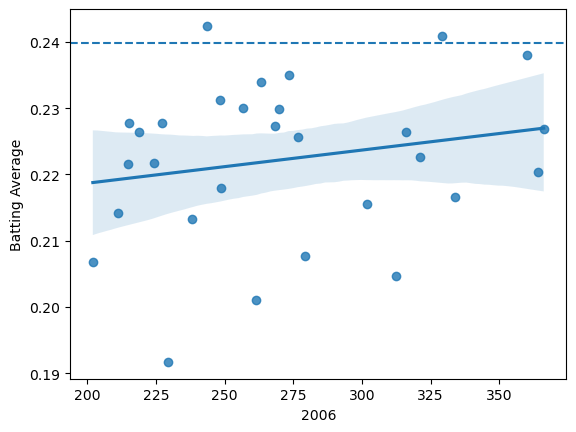

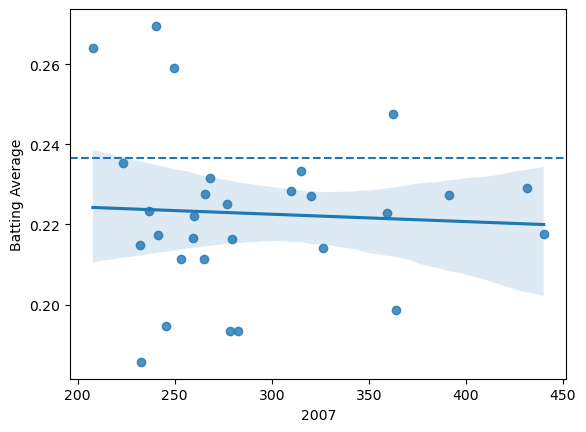

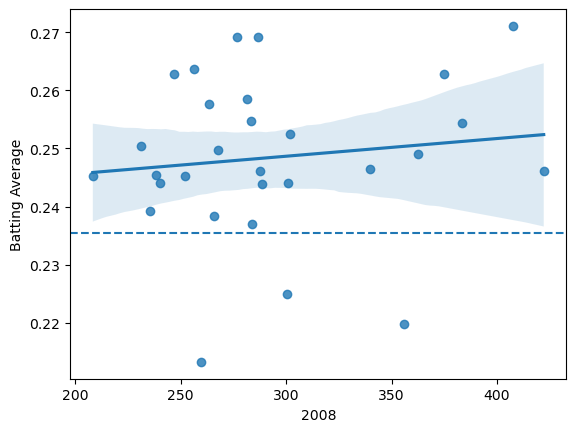

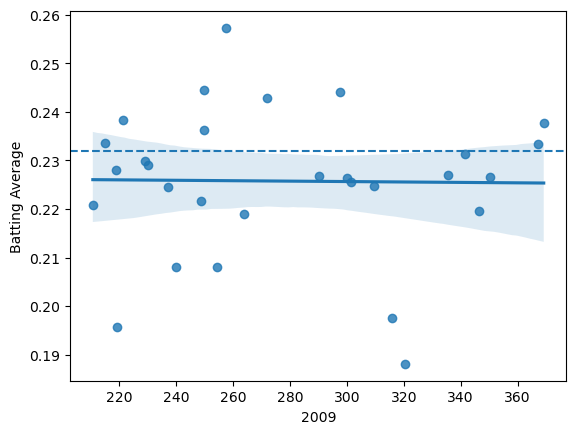

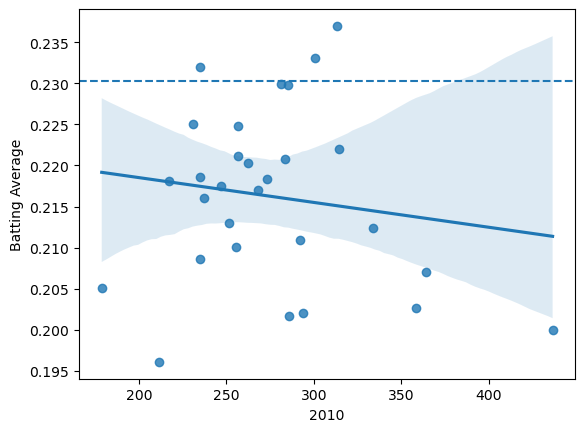

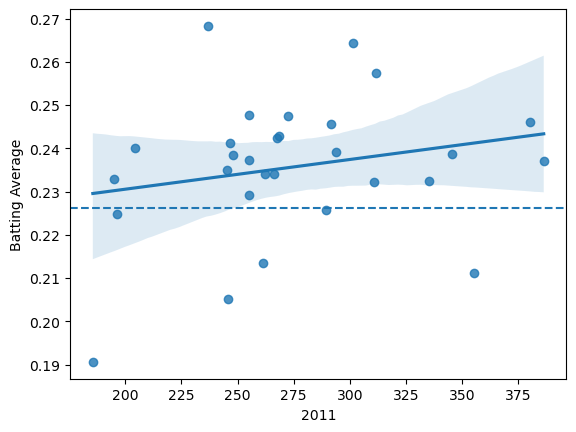

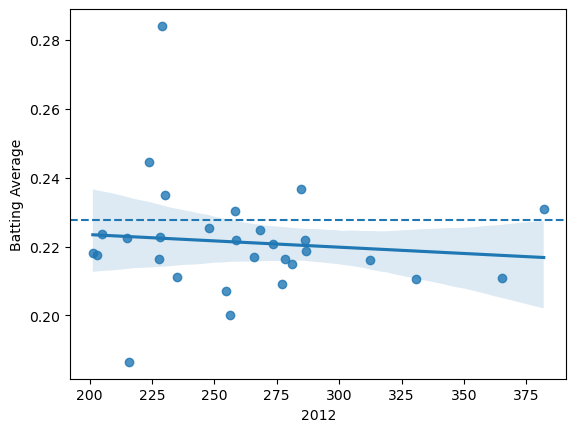

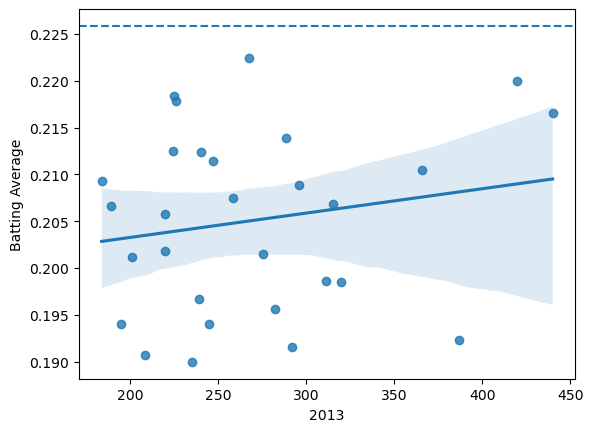

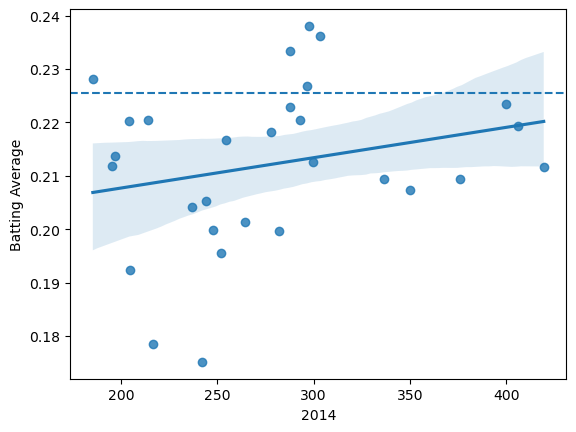

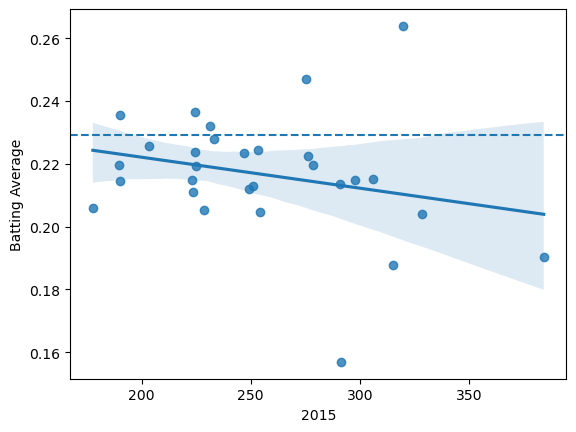

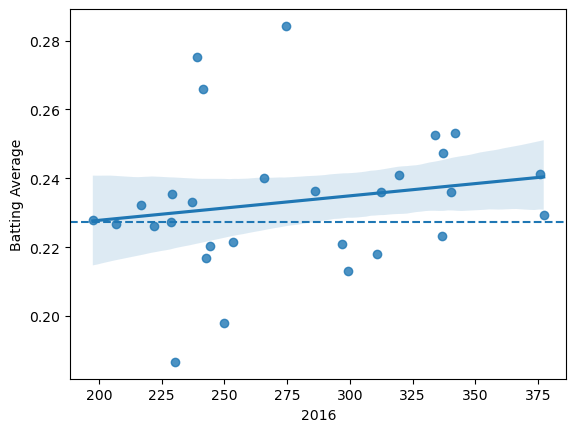

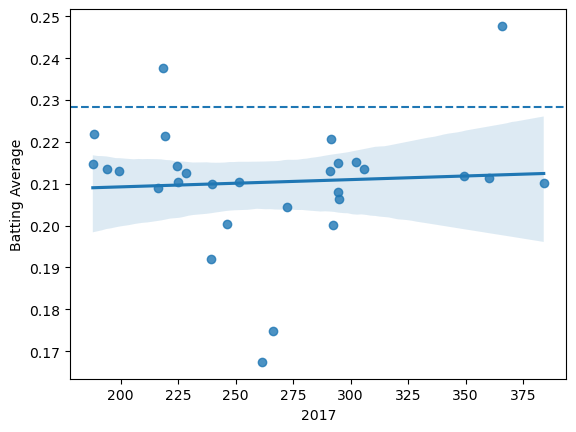

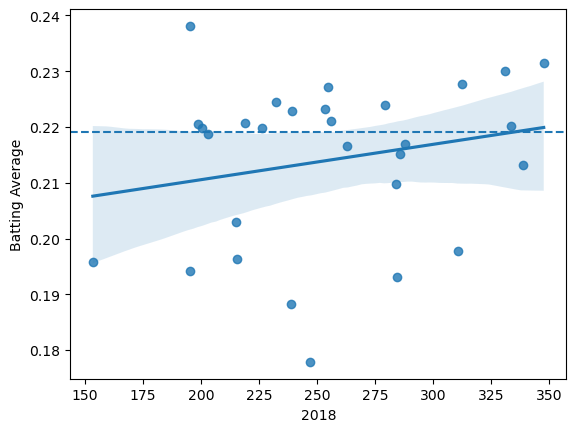

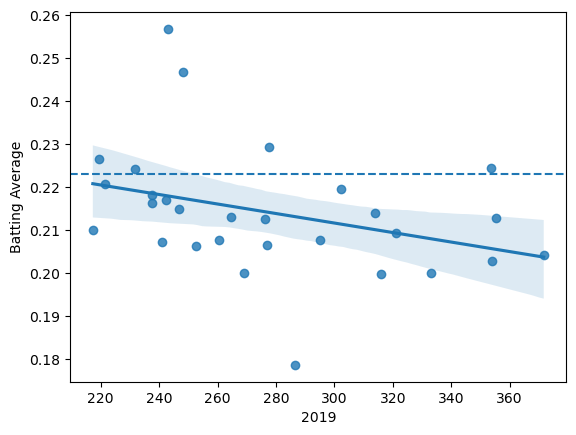

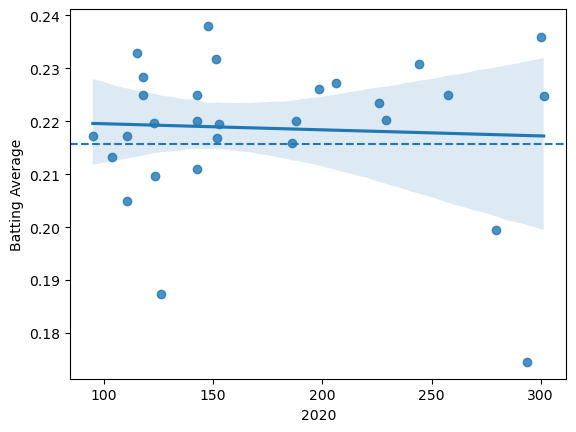

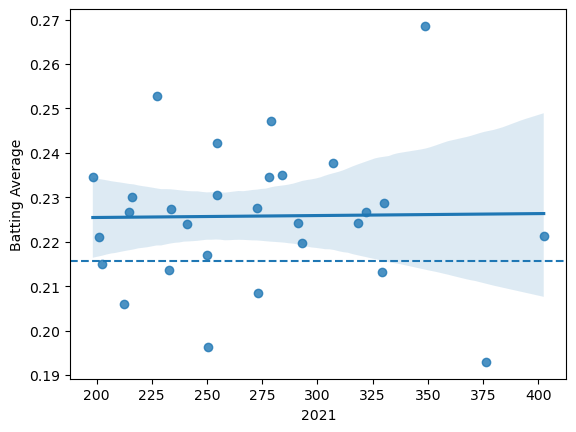

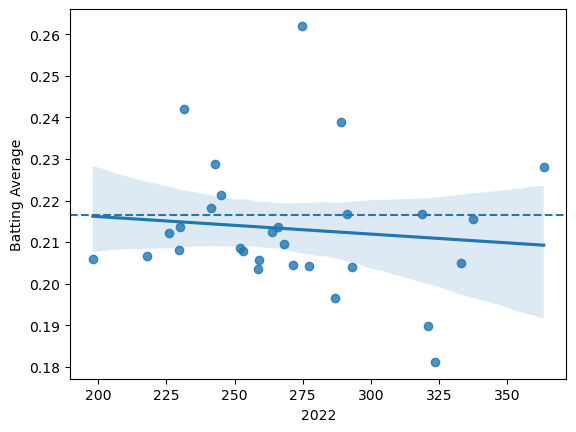

In [227]:
for x in range(0, 23):
    plt.figure()
    ax = sns.regplot(x = pivot_away_dist.iloc[x], y = pivot_away_ba.iloc[x])
    ax.set(ylabel = "Batting Average")
    nation_avg = pivot_home_ba.iloc[x].mean()
    ax.axhline(y = nation_avg, xmin = 0, xmax = 1, linestyle = "dashed")

/tmp/ipykernel_61/4172665531.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


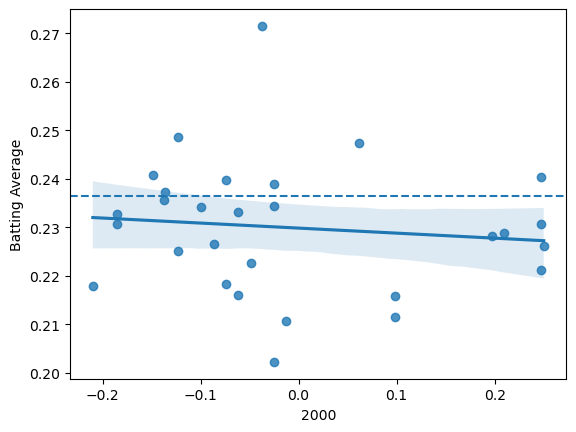

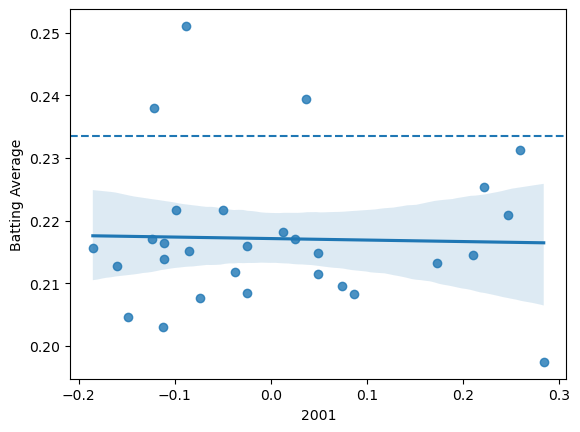

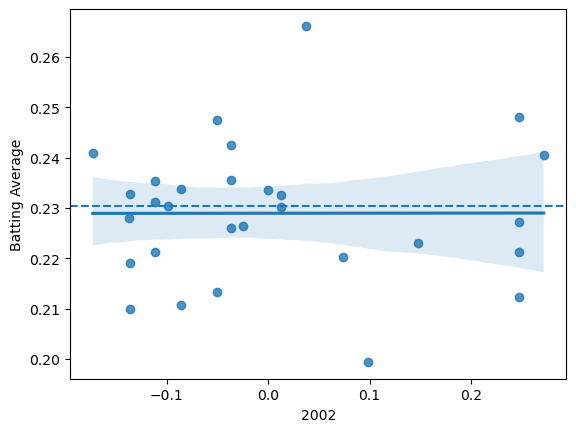

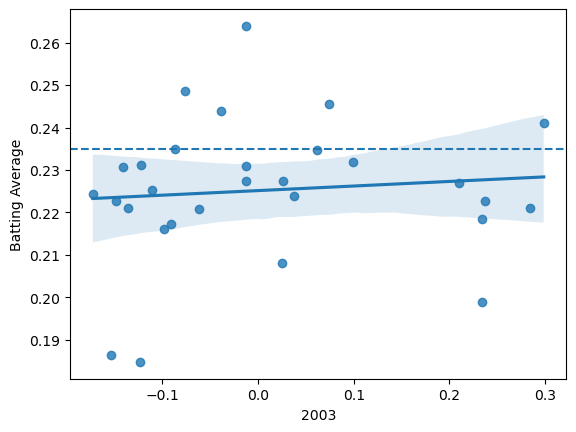

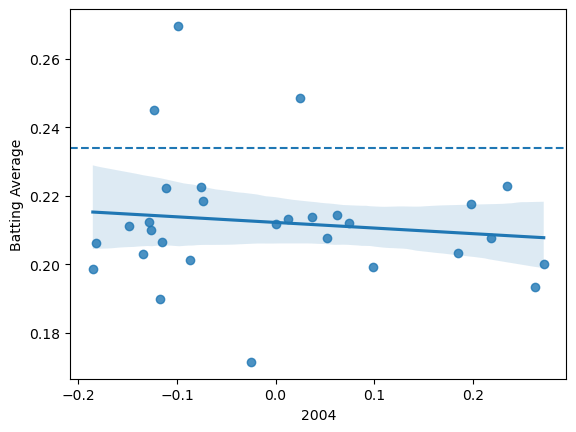

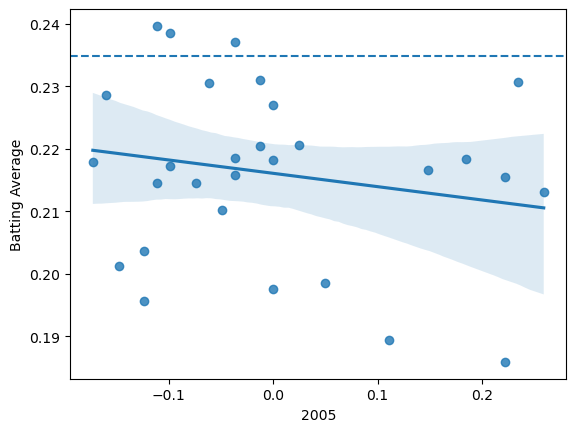

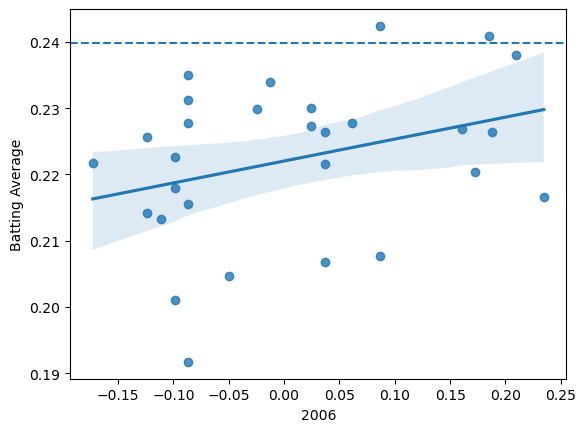

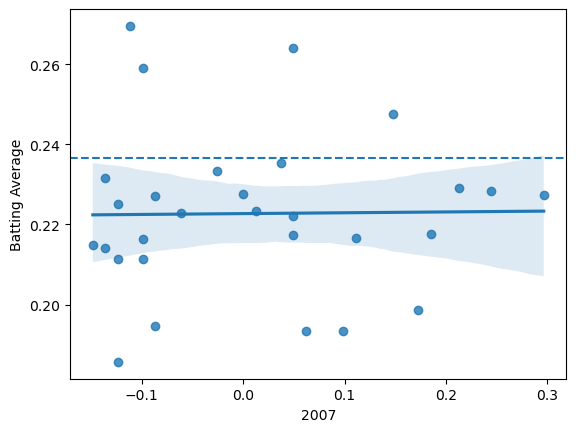

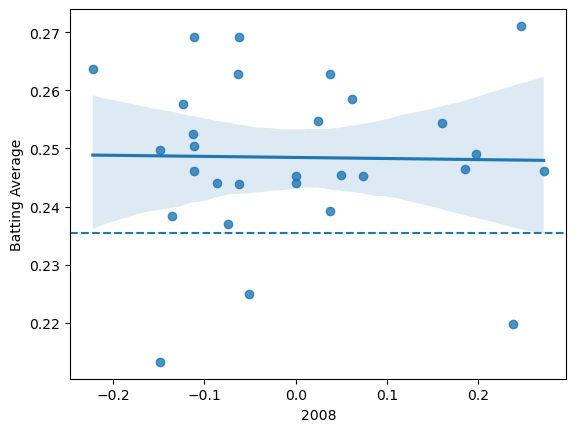

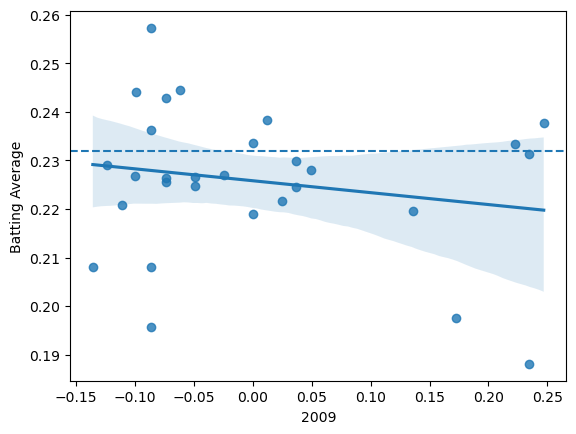

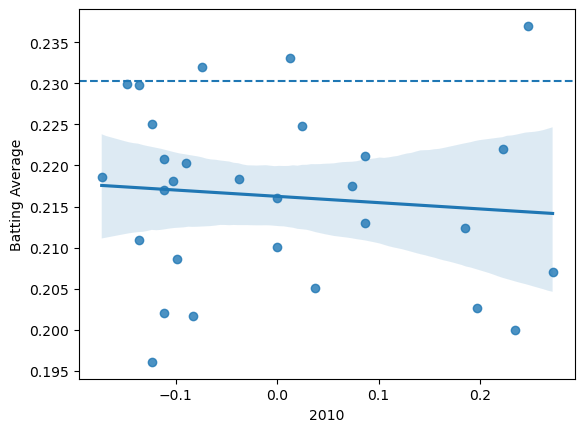

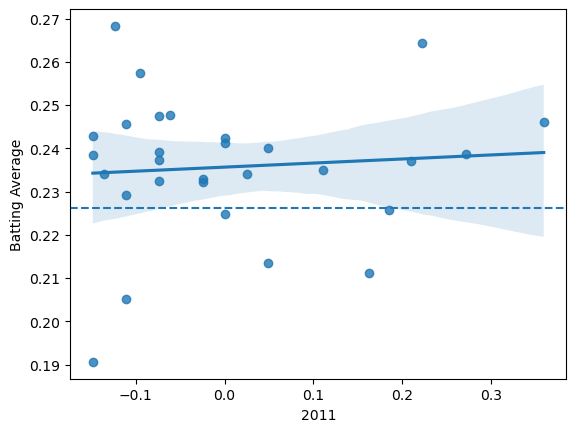

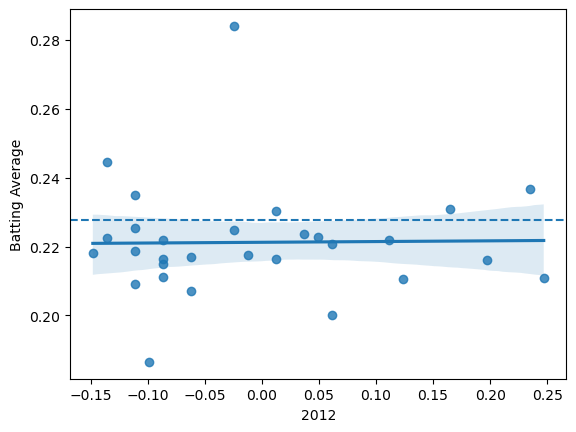

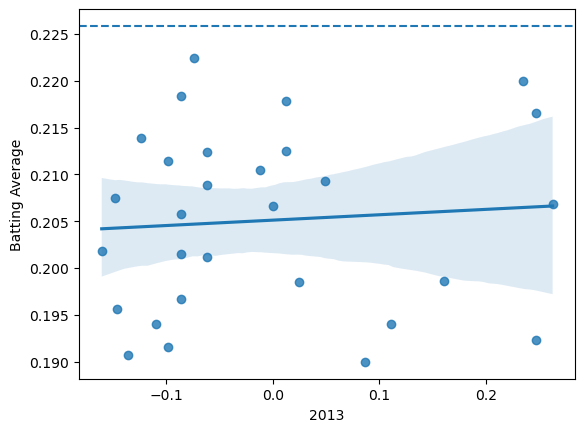

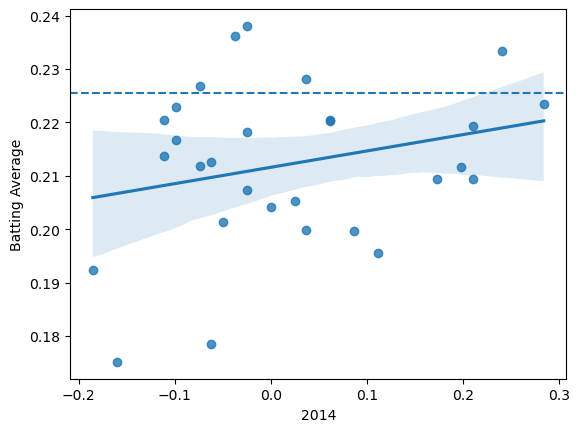

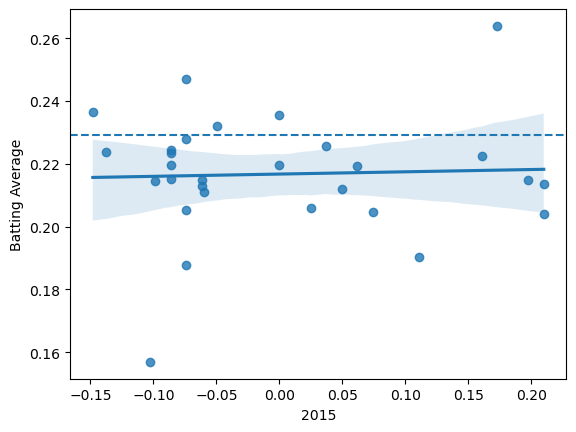

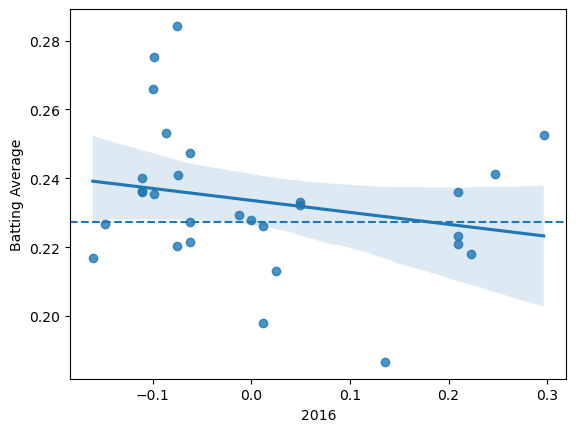

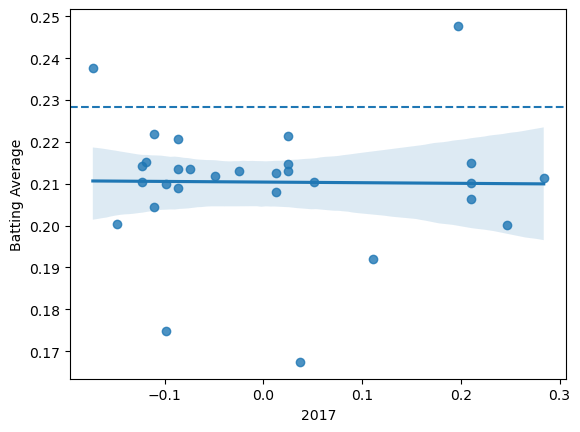

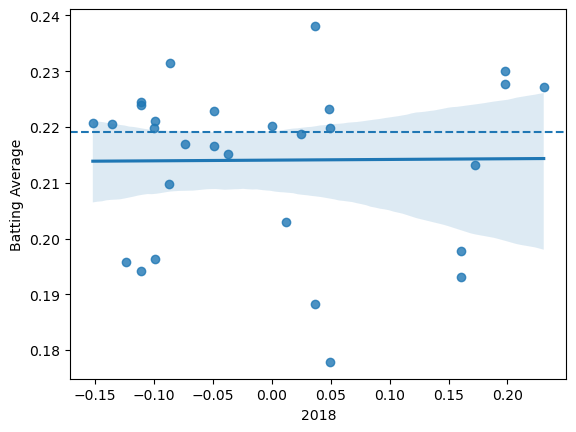

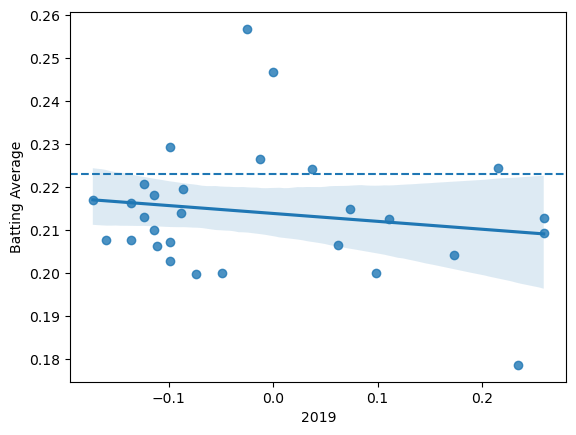

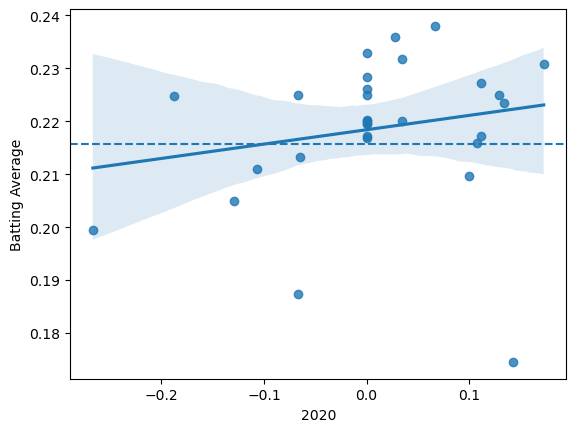

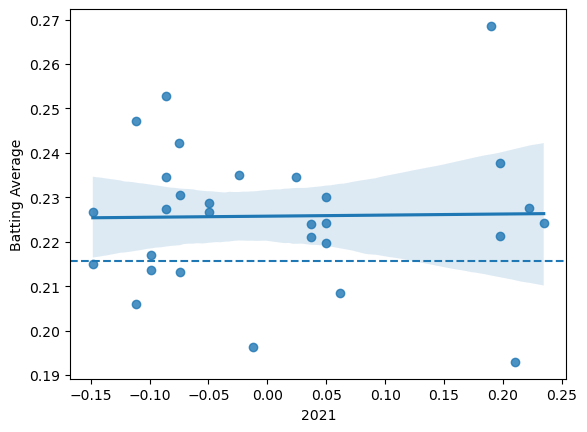

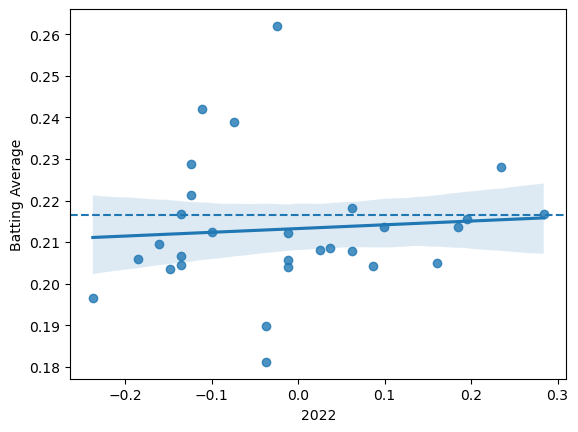

In [226]:
for x in range(0, 23):
    plt.figure()
    ax = sns.regplot(x = pivot_away_tz.iloc[x], y = pivot_away_ba.iloc[x])
    ax.set(ylabel = "Batting Average")
    nation_avg = pivot_home_ba.iloc[x].mean()
    ax.axhline(y = nation_avg, xmin = 0, xmax = 1, linestyle = "dashed")

In [217]:
nation_avg

0.23044688322873938

In [35]:
#splitting dataframe by year
Year2003 = Merger[Merger["year"] == "2003"]

/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


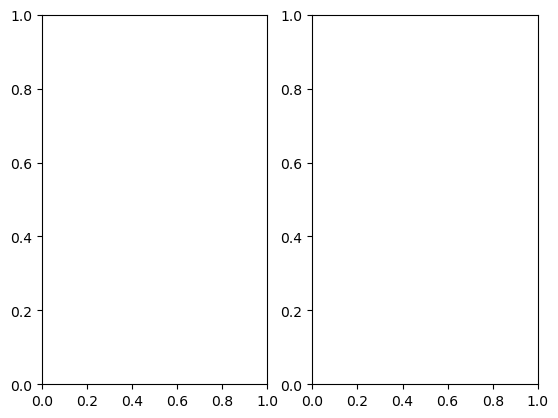

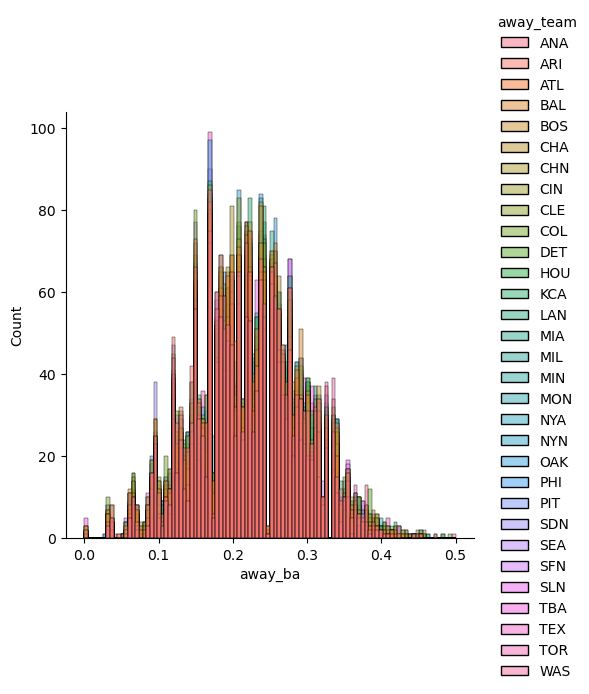

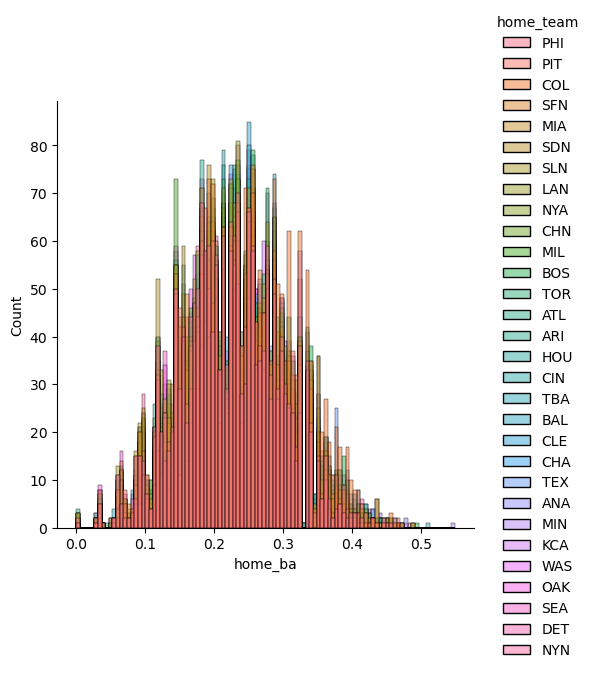

In [48]:
fig, ax = plt.subplots(1,2)
sns.displot(Merger, x = "away_ba", hue = "away_team")
sns.displot(Merger, x = "home_ba", hue = "home_team")
fig.show() 

In [54]:
Year2003["away_ba"].mean()
Year2003["home_ba"].mean()


0.23486427145629918

## Supplementary Data Sources:

MLB Terms and Glossary

https://www.mlb.com/glossary

Team Codes by Year

https://legacy.baseballprospectus.com/sortable/extras/team_codes.php?this_year=2019

Stadium Geolocations:

https://hub.arcgis.com/datasets/f60004d3037e42ad93cb03b9590cafec/explore?location=16.471308%2C-96.237114%2C3.65&showTable=true

Stadium roofs:

https://en.wikipedia.org/wiki/List_of_current_Major_League_Baseball_stadiums

Distance Traveled Map:

https://baseballsavant.mlb.com/visuals/map

List of Alternate Site Games:

https://www.retrosheet.org/neutral.htm

Teams that changed Names Over Years

https://www.mlb.com/news/mlb-teams-that-have-changed-their-name

The Haversine Formula for Distance

https://www.themathdoctors.org/distances-on-earth-2-the-haversine-formula/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b037d64e-a216-4d32-8f49-2e55acb8330d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>